In [1]:
# Jacobian analysis
# initial built: 2024/09/11
# add region dependent Jacobian analysis: 2024/10/02

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import fnmatch

In [2]:
def find_files_with_prefix(directory, prefix):
    matching_files = []
    
    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        # Find files that match the prefix pattern
        for filename in fnmatch.filter(files, prefix + '*'):
            matching_files.append(os.path.join(root, filename))
    
    return matching_files



In [98]:
#instr='amsua'
instr='atms'
ttt='2022070100'

root = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/scrub/chanl_sens_ctrl/gdas.20220701/00/atmos/radstat_tmp'
files = find_files_with_prefix(root, f'diag_{instr}*ges*')

# Print and read the matching files
rr={};
for i, file in enumerate(files):
    print(file)
    rr[i] = nc.Dataset(file)

/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/scrub/chanl_sens_ctrl/gdas.20220701/00/atmos/radstat_tmp/diag_atms_npp_ges.2022070100.nc4
/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/scrub/chanl_sens_ctrl/gdas.20220701/00/atmos/radstat_tmp/diag_atms_n20_ges.2022070100.nc4


In [99]:
ch={}; lat={}; lon={};
inv_obserr={}; obserr={};
clw_obs={}; clw_model={}; clw_sym={};
omf={}; omfnbc={}; 
fwater={};
qc={};
bc_cnst={};
pres={}; u_sfc={}; v_sfc={}; temp={}; q={}; ql={}; qi={}; # inner domain
u_sfc_jac={}; v_sfc_jac={}; temp_jac={}; q_jac={}; ql_jac={}; qi_jac={}; # jacobian

for i, file in enumerate(files):
    ch        [i] = rr[i].variables['Channel_Index'][:]
    lat       [i] = rr[i].variables['Latitude'][:]
    lon       [i] = rr[i].variables['Longitude'][:]
    inv_obserr[i] = rr[i].variables['Inverse_Observation_Error'][:]
    obserr    [i] = rr[i].variables['Sym_Observation_Error'][:]
    clw_obs   [i] = rr[i].variables['clw_obs'][:]
    clw_model [i] = rr[i].variables['clw_guess_retrieval'][:]
    clw_sym   [i] = 0.5*(clw_obs[i] + clw_model[i])
    omf       [i] = rr[i].variables['Obs_Minus_Forecast_adjusted'][:]
    omfnbc    [i] = rr[i].variables['Obs_Minus_Forecast_unadjusted'][:]
    fwater    [i] = rr[i].variables['Water_Fraction'][:]
    qc        [i] = rr[i].variables['QC_Flag'][:]
    bc_cnst   [i] = rr[i].variables['BC_Constant'][:]
    pres      [i] = rr[i].variables['Inner_domain_Pressure'][:]
    u_sfc     [i] = rr[i].variables['Inner_domain_U'][:]
    v_sfc     [i] = rr[i].variables['Inner_domain_V'][:]
    temp      [i] = rr[i].variables['Inner_domain_Temperature'][:]
    q         [i] = rr[i].variables['Inner_domain_Water_Vapor'][:]
    ql        [i] = rr[i].variables['Inner_domain_ql'][:] 
    qi        [i] = rr[i].variables['Inner_domain_qi'][:]
    u_sfc_jac [i] = rr[i].variables['Jacobian_U'][:]
    v_sfc_jac [i] = rr[i].variables['Jacobian_V'][:]
    temp_jac  [i] = rr[i].variables['Jacobian_Temperature'][:]
    q_jac     [i] = rr[i].variables['Jacobian_Water_Vapor'][:]
    ql_jac    [i] = rr[i].variables['Jacobian_ql'][:]
    qi_jac    [i] = rr[i].variables['Jacobian_qi'][:]

In [229]:
# select channel
chn=22
save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/Jacobians/{instr}/'

In [230]:
# pick data criterion and merge data from different satellites:

for i, file in enumerate(files):
    sea_screen  = (fwater[i]>= 0.99)
    use         = np.where( (qc[i] == 0)&(ch[i]==chn)&sea_screen )
    #use         = np.where( (qc == 0)&(ch==chn))
    #use         = np.where( (ch==chn)&sea_screen )
    #use         = np.where( (qc == 0)&(ch==chn)&(cld_rbc_idx==1))
    #use         = np.where( (qc == 0)&(ch==chn)&(varbc_idx==1))
    if i==0:
        lat_use        = lat[i][use]
        lon_use        = lon[i][use]
        obserr_use     = obserr[i][use]
        inv_obserr_use = inv_obserr[i][use]
        clw_sym_use    = clw_sym[i][use]
        clw_obs_use    = clw_obs[i][use]
        clw_model_use  = clw_model[i][use]
        omf_use        = omf[i][use]
        omfnbc_use     = omfnbc[i][use]
        bc_cnst_use    = bc_cnst[i][0]
        pres_use       = pres[i][use]
        u_sfc_use      = u_sfc[i][use]
        v_sfc_use      = v_sfc[i][use]
        temp_use       = temp[i][use]
        q_use          = q[i][use]
        ql_use         = ql[i][use]
        qi_use         = qi[i][use]
        u_sfc_jac_use  = u_sfc_jac[i][use]
        v_sfc_jac_use  = v_sfc_jac[i][use]
        temp_jac_use   = temp_jac[i][use]
        q_jac_use      = q_jac[i][use]
        ql_jac_use     = ql_jac[i][use]
        qi_jac_use     = qi_jac[i][use]
    else:
        lat_use        = np.append(lat_use,        lat[i][use])
        lon_use        = np.append(lon_use,        lon[i][use])
        obserr_use     = np.append(obserr_use,     obserr[i][use])
        inv_obserr_use = np.append(inv_obserr_use, inv_obserr[i][use])
        clw_sym_use    = np.append(clw_sym_use,    clw_sym[i][use])
        clw_obs_use    = np.append(clw_obs_use,    clw_obs[i][use])
        clw_model_use  = np.append(clw_model_use,  clw_model[i][use])
        omf_use        = np.append(omf_use,        omf[i][use])
        omfnbc_use     = np.append(omfnbc_use,     omfnbc[i][use])
        bc_cnst_use    = np.append(bc_cnst_use,    bc_cnst[i][0])
        pres_use       = np.concatenate((pres_use, pres[i][use]), axis=0)
        u_sfc_use      = np.append(u_sfc_use,      u_sfc[i][use])
        v_sfc_use      = np.append(v_sfc_use,      v_sfc[i][use])
        temp_use       = np.concatenate((temp_use, temp[i][use]), axis=0)
        q_use          = np.concatenate((q_use, q[i][use]), axis=0)
        ql_use         = np.concatenate((ql_use, ql[i][use]), axis=0)
        qi_use         = np.concatenate((qi_use, qi[i][use]), axis=0)
        u_sfc_jac_use  = np.append(u_sfc_jac_use,  u_sfc_jac[i][use])
        v_sfc_jac_use  = np.append(v_sfc_jac_use,  v_sfc_jac[i][use])
        temp_jac_use   = np.concatenate((temp_jac_use, temp_jac[i][use]), axis=0)
        q_jac_use      = np.concatenate((q_jac_use, q_jac[i][use]), axis=0)
        ql_jac_use     = np.concatenate((ql_jac_use, ql_jac[i][use]), axis=0)
        qi_jac_use     = np.concatenate((qi_jac_use, qi_jac[i][use]), axis=0)        

In [185]:
pres_use.shape
q_jac_use.shape

(11630, 94)

In [231]:
# interpolate the Jacobian and the inner domain to the same vertical grid:
pres_interp= np.array( [0.5, 1.0, 3.0, 5.0, 10.0, 20.0, 30.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0, \
                        250.0, 275.0, 300.0, 325.0, 350.0, 375.0, 400.0, 425.0, 450.0, 475.0, 500.0, \
                        525.0, 550.0, 575.0, 600.0, 625.0, 650.0, 675.0, 700.0, 725.0, 750.0, 775.0, \
                        800.0, 825.0, 850.0, 875.0, 900.0, 925.0, 950.0, 975.0, 1000.0, 1025.0])

ndata     = len(pres_use)
nlev_orig = len(pres_use[0])
nlev_interp = len(pres_interp)

q_interp = np.zeros((ndata, nlev_interp))
t_interp = np.zeros((ndata, nlev_interp))
ql_interp = np.zeros((ndata, nlev_interp))
qi_interp = np.zeros((ndata, nlev_interp))

q_jac_interp = np.zeros((ndata, nlev_interp))
t_jac_interp = np.zeros((ndata, nlev_interp))
ql_jac_interp = np.zeros((ndata, nlev_interp))
qi_jac_interp = np.zeros((ndata, nlev_interp))


for i in range(ndata):
    q_interp[i,:] = np.interp(pres_interp, pres_use[i], q_use[i])
    t_interp[i,:] = np.interp(pres_interp, pres_use[i], temp_use[i])
    ql_interp[i,:] = np.interp(pres_interp, pres_use[i], ql_use[i])
    qi_interp[i,:] = np.interp(pres_interp, pres_use[i], qi_use[i])

    q_jac_interp[i,:] = np.interp(pres_interp, pres_use[i], q_jac_use[i]*q_use[i]*0.1)
    t_jac_interp[i,:] = np.interp(pres_interp, pres_use[i], temp_jac_use[i])
    ql_jac_interp[i,:] = np.interp(pres_interp, pres_use[i], ql_jac_use[i])
    qi_jac_interp[i,:] = np.interp(pres_interp, pres_use[i], qi_jac_use[i])


In [106]:
# T jacobian xlimit:
if chn == 1:
    xlim_r = [-0.001, 0.013]
elif chn == 2:
    xlim_r = [-0.007, 0.001]
elif chn == 3:
    xlim_r = [-0.003, 0.008]
elif chn == 4:
    xlim_r = [-0.002, 0.022]
elif chn == 5:
    xlim_r = [-0.002, 0.025]
elif chn == 6:
    xlim_r = [-0.002, 0.025]
elif chn == 15:
    xlim_r = [-0.008, 0.006]
elif chn == 16:
    xlim_r = [-0.010, 0.006]
elif chn == 17:
    xlim_r = [-0.01, 0.05]
elif chn == 18:
    xlim_r = [-0.01, 0.07]
elif chn == 19:
    xlim_r = [-0.01, 0.07]
elif chn == 20:
    xlim_r = [-0.01, 0.07]  
elif chn == 21:
    xlim_r = [-0.01, 0.08]     
elif chn == 22:
    xlim_r = [-0.01, 0.09] 
else:
    xlim_r = [-0.01,0.10]

In [ ]:
# Global T-jacobian

use_prof = t_interp

prof_mean = np.mean(use_prof, axis=0)
prof_std  = np.std(use_prof, axis=0)
prof_q25  = np.quantile(use_prof, 0.25, axis=0)
prof_q50  = np.quantile(use_prof, 0.50, axis=0)
prof_q75  = np.quantile(use_prof, 0.75, axis=0)

use_jac = t_jac_interp

jac_mean = np.mean(use_jac, axis=0)
jac_std  = np.std(use_jac, axis=0)
jac_q25  = np.quantile(use_jac, 0.25, axis=0)
jac_q50  = np.quantile(use_jac, 0.50, axis=0)
jac_q75  = np.quantile(use_jac, 0.75, axis=0)

# profile:
'''
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(prof_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(prof_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(prof_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, prof_q25, prof_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ T$ [K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(f'{instr} ch{chn} - T profile (Global)', fontsize=16)

if save_fig:
    plt.savefig(f'{instr}_ch{chn}_{ttt}_Tprof_global.png', dpi=200, bbox_inches='tight')
'''

# jacobian
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, jac_q25, jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ \partial T_B / \partial T$  [K/K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(f'{instr} ch{chn} - T Jacobian (Global)', fontsize=16)

if save_fig:
    plt.savefig(f'{fig_dir}/{instr}_ch{chn}_{ttt}_Tjac_global.png', dpi=200, bbox_inches='tight')

In [ ]:
# T-jacobian for different latitude

prof_mean={}; prof_std={}; prof_q25={}; prof_q50={}; prof_q75={};
jac_mean={}; jac_std={}; jac_q25={}; jac_q50={}; jac_q75={};

regions=['60-90','30-60','0-30']

for rg in regions:
    if rg == '0-30':
        use = np.where( np.abs(lat_use)<=30 )
    elif rg == '30-60':
        use = np.where( (np.abs(lat_use) >30) & (np.abs(lat_use) <=60) )
    elif rg == '60-90':
        use = np.where( (np.abs(lat_use) >60) & (np.abs(lat_use) <=90) )

    use_prof = t_interp[use[0],:]

    prof_mean[rg] = np.mean(use_prof, axis=0)
    prof_std [rg] = np.std(use_prof, axis=0)
    prof_q25 [rg] = np.quantile(use_prof, 0.25, axis=0)
    prof_q50 [rg] = np.quantile(use_prof, 0.50, axis=0)
    prof_q75 [rg] = np.quantile(use_prof, 0.75, axis=0)

    use_jac = t_jac_interp[use[0],:]

    jac_mean [rg] = np.mean(use_jac, axis=0)
    jac_std  [rg] = np.std(use_jac, axis=0)
    jac_q25  [rg] = np.quantile(use_jac, 0.25, axis=0)
    jac_q50  [rg] = np.quantile(use_jac, 0.50, axis=0)
    jac_q75  [rg] = np.quantile(use_jac, 0.75, axis=0)

# profile:
'''
fig, ax = plt.subplots(figsize=(6,5))
for rg in regions:
    ax.plot(prof_q50[rg], pres_interp, color=(0.2,0.2,0.2), linestyle='--')
    ax.plot(prof_q25[rg], pres_interp, color=(0.2,0.2,0.2))
    ax.plot(prof_q75[rg], pres_interp, color=(0.2,0.2,0.2))
    ax.fill_betweenx(pres_interp, prof_q25[rg], prof_q75[rg], color='gray', alpha=0.5)
                       
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ T$ [K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(rf'{instr} ch{chn} - T profile', fontsize=16)

if save_fig:
    plt.savefig(f'{instr}_ch{chn}_{ttt}_Tprof_region_dependent.png', dpi=200, bbox_inches='tight')
'''

# jacobian
fig, ax = plt.subplots(figsize=(6,5))
for rg in regions:
    if rg == '0-30':
        line_color  = np.array((204,102,  0))/255
        shade_color = np.array((255,178,102))/255
        legend = rf'$0\degree-30\degree$'
    elif rg == '30-60':
        line_color  = np.array((  0,153,  0))/255
        shade_color = np.array((178,255,102))/255
        legend = rf'$30\degree-60\degree$'
    elif rg == '60-90':
        line_color  = np.array((  0, 76,153))/255
        shade_color = np.array((102,178,255))/255
        legend = rf'$60\degree-90\degree$'

    ax.plot(jac_q50[rg], pres_interp, color=line_color, linestyle='--')
    ax.plot(jac_q25[rg], pres_interp, color=line_color, label=legend)
    ax.plot(jac_q75[rg], pres_interp, color=line_color)
    ax.fill_betweenx(pres_interp, jac_q25[rg], jac_q75[rg], color=shade_color, alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ \partial T_B / \partial T$  [K/K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.legend(fontsize=12)
ax.set_title(f'{instr} ch{chn} - T Jacobian', fontsize=16)

if save_fig:
    plt.savefig(f'{fig_dir}/{instr}_ch{chn}_{ttt}_Tjac_region_dependent.png', dpi=200, bbox_inches='tight')

In [ ]:
# clear/cloudy sky T-profile and T-jacobian:
    
use_clr = np.where(clw_model_use <=0.03)
use_cld = np.where(clw_model_use  >0.03)

clr_prof = t_interp[use_clr[0],:]
cld_prof = t_interp[use_cld[0],:]

clr_prof_mean = np.mean(clr_prof, axis=0)
cld_prof_std  = np.std(clr_prof, axis=0)
clr_prof_q25  = np.quantile(clr_prof, 0.25, axis=0)
clr_prof_q50  = np.quantile(clr_prof, 0.50, axis=0)
clr_prof_q75  = np.quantile(clr_prof, 0.75, axis=0)
cld_prof_mean = np.mean(cld_prof, axis=0)
cld_prof_std  = np.std(cld_prof, axis=0)
cld_prof_q25  = np.quantile(cld_prof, 0.25, axis=0)
cld_prof_q50  = np.quantile(cld_prof, 0.50, axis=0)
cld_prof_q75  = np.quantile(cld_prof, 0.75, axis=0)


clr_jac  = t_jac_interp[use_clr[0],:]
cld_jac  = t_jac_interp[use_cld[0],:]

clr_jac_mean = np.mean(clr_jac, axis=0)
clr_jac_std  = np.std(clr_jac, axis=0)
clr_jac_q25  = np.quantile(clr_jac, 0.25, axis=0)
clr_jac_q50  = np.quantile(clr_jac, 0.50, axis=0)
clr_jac_q75  = np.quantile(clr_jac, 0.75, axis=0)
cld_jac_mean = np.mean(cld_jac, axis=0)
cld_jac_std  = np.std(cld_jac, axis=0)
cld_jac_q25  = np.quantile(cld_jac, 0.25, axis=0)
cld_jac_q50  = np.quantile(cld_jac, 0.50, axis=0)
cld_jac_q75  = np.quantile(cld_jac, 0.75, axis=0)


fig, ax = plt.subplots(figsize=(6,5))
ax.plot(clr_jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(clr_jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(clr_jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, clr_jac_q25, clr_jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ \partial T_B / \partial T$  [K/K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(f'{instr} ch{chn} - T Jacobian (clear)', fontsize=16)

if save_fig:
    plt.savefig(f'{fig_dir}/{instr}_ch{chn}_{ttt}_Tjac_clear.png', dpi=200, bbox_inches='tight')


fig, ax = plt.subplots(figsize=(6,5))
ax.plot(cld_jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(cld_jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(cld_jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, cld_jac_q25, cld_jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ \partial T_B / \partial T$  [K/K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(f'{instr} ch{chn} - T Jacobian (cloudy)', fontsize=16)

if save_fig:
    plt.savefig(f'{fig_dir}/{instr}_ch{chn}_{ttt}_Tjac_cloudy.png', dpi=200, bbox_inches='tight')


In [235]:
# Q jacobian xlimit:
if chn == 1:
    xlim_r = [-0.03, 0.33]
elif chn == 2:
    xlim_r = [-0.005, 0.16]
elif chn == 3:
    xlim_r = [-0.005, 0.11]
elif chn == 4:
    if instr=='amsua':
        xlim_r = [-0.005, 0.025]
    elif instr=='atms':
        xlim_r = [-0.01, 0.07]
elif chn == 5:
    if instr=='amsua':
        xlim_r = [-0.002, 0.004]
    elif instr=='atms':
        xlim_r = [-0.002, 0.025]
elif chn == 6:
    xlim_r = [-0.001, 0.005]
elif chn == 15:
    xlim_r = [-0.03, 0.28]
elif chn == 16:
    xlim_r = [-0.03, 0.28]
elif chn == 17:
    xlim_r = [-0.05, 0.15]    
elif chn == 18:
    xlim_r = [-0.05, 0.02] 
elif chn == 19:
    xlim_r = [-0.06, 0.01]     
elif chn == 20:
    xlim_r = [-0.07, 0.01] 
elif chn == 21:
    xlim_r = [-0.09, 0.01]   
elif chn == 22:
    xlim_r = [-0.10, 0.01]    

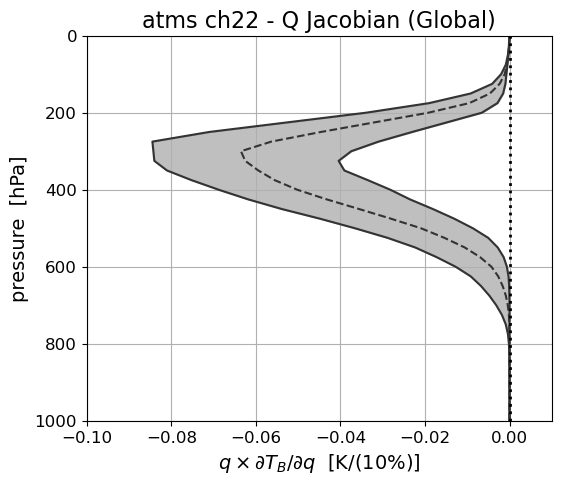

In [236]:
# Global Q-jacobian
    
use_prof = q_interp

prof_mean = np.mean(use_prof, axis=0)
prof_std  = np.std(use_prof, axis=0)
prof_q25  = np.quantile(use_prof, 0.25, axis=0)
prof_q50  = np.quantile(use_prof, 0.50, axis=0)
prof_q75  = np.quantile(use_prof, 0.75, axis=0)

use_jac = q_jac_interp

jac_mean = np.mean(use_jac, axis=0)
jac_std  = np.std(use_jac, axis=0)
jac_q25  = np.quantile(use_jac, 0.25, axis=0)
jac_q50  = np.quantile(use_jac, 0.50, axis=0)
jac_q75  = np.quantile(use_jac, 0.75, axis=0)

# profile:
'''
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(prof_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(prof_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(prof_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, prof_q25, prof_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ Q$ [g/kg]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(f'{instr} ch{chn} - Q profile (Global)', fontsize=16)

if save_fig:
    plt.savefig(f'{instr}_ch{chn}_{ttt}_Qprof_global.png', dpi=200, bbox_inches='tight')
'''

# jacobian
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, jac_q25, jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ q \times \partial T_B / \partial q$  [K/(10%)]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(f'{instr} ch{chn} - Q Jacobian (Global)', fontsize=16)

if save_fig:
    plt.savefig(f'{fig_dir}/{instr}_ch{chn}_{ttt}_Qjac_global.png', dpi=200, bbox_inches='tight')

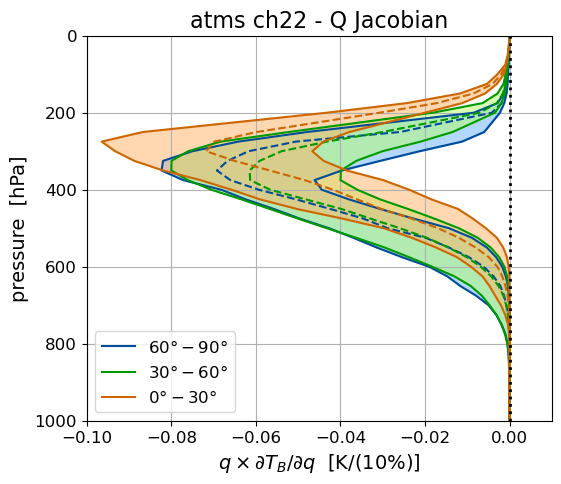

In [237]:
# Q-jacobian for different latitude

prof_mean={}; prof_std={}; prof_q25={}; prof_q50={}; prof_q75={};
jac_mean={}; jac_std={}; jac_q25={}; jac_q50={}; jac_q75={};

regions=['60-90','30-60','0-30']

for rg in regions:
    if rg == '0-30':
        use = np.where( np.abs(lat_use)<=30 )
    elif rg == '30-60':
        use = np.where( (np.abs(lat_use) >30) & (np.abs(lat_use) <=60) )
    elif rg == '60-90':
        use = np.where( (np.abs(lat_use) >60) & (np.abs(lat_use) <=90) )

    use_prof = q_interp[use[0],:]

    prof_mean[rg] = np.mean(use_prof, axis=0)
    prof_std [rg] = np.std(use_prof, axis=0)
    prof_q25 [rg] = np.quantile(use_prof, 0.25, axis=0)
    prof_q50 [rg] = np.quantile(use_prof, 0.50, axis=0)
    prof_q75 [rg] = np.quantile(use_prof, 0.75, axis=0)

    use_jac = q_jac_interp[use[0],:]

    jac_mean [rg] = np.mean(use_jac, axis=0)
    jac_std  [rg] = np.std(use_jac, axis=0)
    jac_q25  [rg] = np.quantile(use_jac, 0.25, axis=0)
    jac_q50  [rg] = np.quantile(use_jac, 0.50, axis=0)
    jac_q75  [rg] = np.quantile(use_jac, 0.75, axis=0)

# profile:
'''
fig, ax = plt.subplots(figsize=(6,5))
for rg in regions:
    ax.plot(prof_q50[rg], pres_interp, color=(0.2,0.2,0.2), linestyle='--')
    ax.plot(prof_q25[rg], pres_interp, color=(0.2,0.2,0.2))
    ax.plot(prof_q75[rg], pres_interp, color=(0.2,0.2,0.2))
    ax.fill_betweenx(pres_interp, prof_q25[rg], prof_q75[rg], color='gray', alpha=0.5)
                       
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ Q$ [g/kg]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(rf'{instr} ch{chn} - Q profile', fontsize=16)

if save_fig:
    plt.savefig(f'{instr}_ch{chn}_{ttt}_Qprof_region_dependent.png', dpi=200, bbox_inches='tight')
'''

# jacobian
fig, ax = plt.subplots(figsize=(6,5))
for rg in regions:
    if rg == '0-30':
        line_color  = np.array((204,102,  0))/255
        shade_color = np.array((255,178,102))/255
        legend = rf'$0\degree-30\degree$'
    elif rg == '30-60':
        line_color  = np.array((  0,153,  0))/255
        shade_color = np.array((178,255,102))/255
        legend = rf'$30\degree-60\degree$'
    elif rg == '60-90':
        line_color  = np.array((  0, 76,153))/255
        shade_color = np.array((102,178,255))/255
        legend = rf'$60\degree-90\degree$'

    ax.plot(jac_q50[rg], pres_interp, color=line_color, linestyle='--')
    ax.plot(jac_q25[rg], pres_interp, color=line_color, label=legend)
    ax.plot(jac_q75[rg], pres_interp, color=line_color)
    ax.fill_betweenx(pres_interp, jac_q25[rg], jac_q75[rg], color=shade_color, alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ q \times \partial T_B / \partial q$  [K/(10%)]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.legend(fontsize=12)
ax.set_title(f'{instr} ch{chn} - Q Jacobian', fontsize=16)

if save_fig:
    plt.savefig(f'{fig_dir}/{instr}_ch{chn}_{ttt}_Qjac_region_dependent.png', dpi=200, bbox_inches='tight')

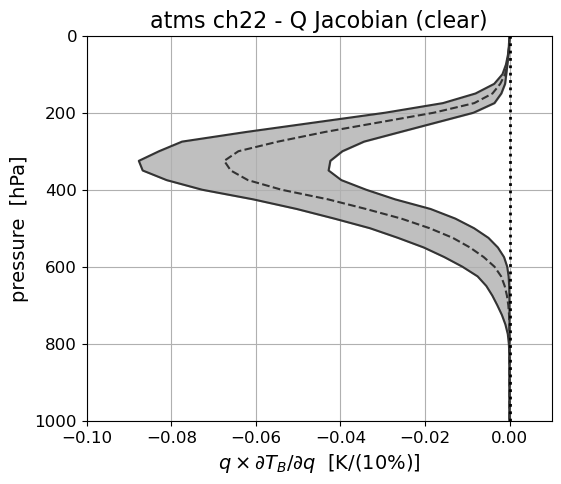

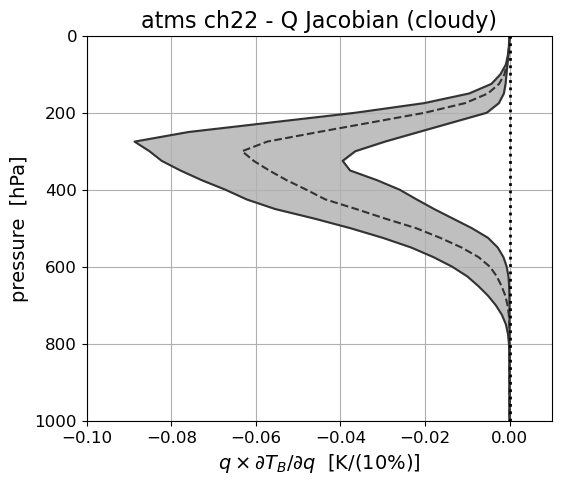

In [238]:
# clear/cloudy sky Q-profile and Q-jacobian:
 
    
use_clr = np.where(clw_model_use <=0.03)
use_cld = np.where(clw_model_use  >0.03)

clr_prof = q_interp[use_clr[0],:]
cld_prof = q_interp[use_cld[0],:]

clr_prof_mean = np.mean(clr_prof, axis=0)
cld_prof_std  = np.std(clr_prof, axis=0)
clr_prof_q25  = np.quantile(clr_prof, 0.25, axis=0)
clr_prof_q50  = np.quantile(clr_prof, 0.50, axis=0)
clr_prof_q75  = np.quantile(clr_prof, 0.75, axis=0)
cld_prof_mean = np.mean(cld_prof, axis=0)
cld_prof_std  = np.std(cld_prof, axis=0)
cld_prof_q25  = np.quantile(cld_prof, 0.25, axis=0)
cld_prof_q50  = np.quantile(cld_prof, 0.50, axis=0)
cld_prof_q75  = np.quantile(cld_prof, 0.75, axis=0)


clr_jac  = q_jac_interp[use_clr[0],:]
cld_jac  = q_jac_interp[use_cld[0],:]

clr_jac_mean = np.mean(clr_jac, axis=0)
clr_jac_std  = np.std(clr_jac, axis=0)
clr_jac_q25  = np.quantile(clr_jac, 0.25, axis=0)
clr_jac_q50  = np.quantile(clr_jac, 0.50, axis=0)
clr_jac_q75  = np.quantile(clr_jac, 0.75, axis=0)
cld_jac_mean = np.mean(cld_jac, axis=0)
cld_jac_std  = np.std(cld_jac, axis=0)
cld_jac_q25  = np.quantile(cld_jac, 0.25, axis=0)
cld_jac_q50  = np.quantile(cld_jac, 0.50, axis=0)
cld_jac_q75  = np.quantile(cld_jac, 0.75, axis=0)


fig, ax = plt.subplots(figsize=(6,5))
ax.plot(clr_jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(clr_jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(clr_jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, clr_jac_q25, clr_jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ q \times \partial T_B / \partial q$  [K/(10%)]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(f'{instr} ch{chn} - Q Jacobian (clear)', fontsize=16)

if save_fig:
    plt.savefig(f'{fig_dir}/{instr}_ch{chn}_{ttt}_Qjac_clear.png', dpi=200, bbox_inches='tight')
    
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(cld_jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(cld_jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(cld_jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, cld_jac_q25, cld_jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ q \times \partial T_B / \partial q$  [K/(10%)]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(f'{instr} ch{chn} - Q Jacobian (cloudy)', fontsize=16)

if save_fig:
    plt.savefig(f'{fig_dir}/{instr}_ch{chn}_{ttt}_Qjac_cloudy.png', dpi=200, bbox_inches='tight')

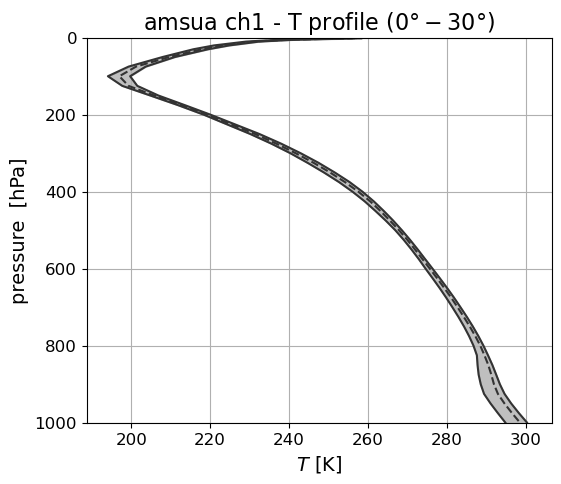

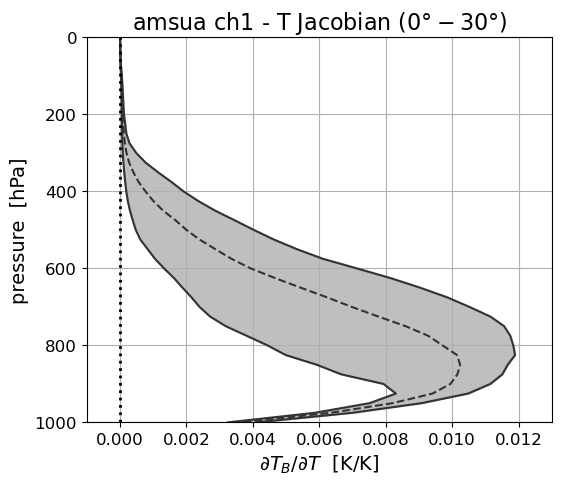

In [ ]:
# [0,30] degree T-jacobian
 
use = np.where( np.abs(lat_use) <=30)

use_prof = t_interp[use[0],:]

prof_mean = np.mean(use_prof, axis=0)
prof_std  = np.std(use_prof, axis=0)
prof_q25  = np.quantile(use_prof, 0.25, axis=0)
prof_q50  = np.quantile(use_prof, 0.50, axis=0)
prof_q75  = np.quantile(use_prof, 0.75, axis=0)

use_jac = t_jac_interp[use[0],:]

jac_mean = np.mean(use_jac, axis=0)
jac_std  = np.std(use_jac, axis=0)
jac_q25  = np.quantile(use_jac, 0.25, axis=0)
jac_q50  = np.quantile(use_jac, 0.50, axis=0)
jac_q75  = np.quantile(use_jac, 0.75, axis=0)


# profile:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(prof_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(prof_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(prof_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, prof_q25, prof_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ T$ [K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(rf'{instr} ch{chn} - T profile ($0\degree-30\degree$)', fontsize=16)

if save_fig:
    plt.savefig(f'{instr}_ch{chn}_{ttt}_Tprof_0_30.png', dpi=200, bbox_inches='tight')

# jacobian
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, jac_q25, jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ \partial T_B / \partial T$  [K/K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(f'{instr} ch{chn} - T Jacobian ($0\degree-30\degree$)', fontsize=16)

if save_fig:
    plt.savefig(f'{instr}_ch{chn}_{ttt}_Tjac_0_30.png', dpi=200, bbox_inches='tight')


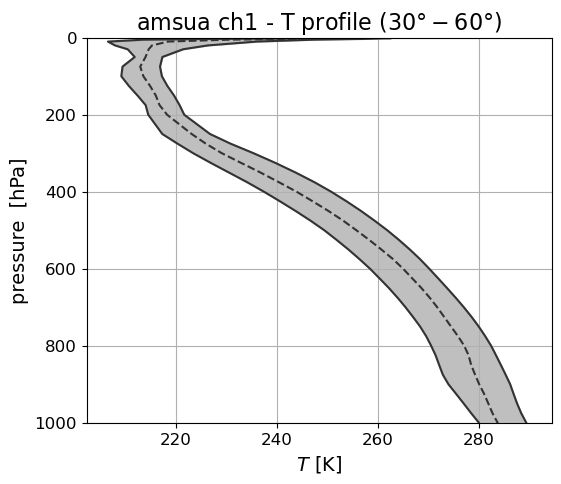

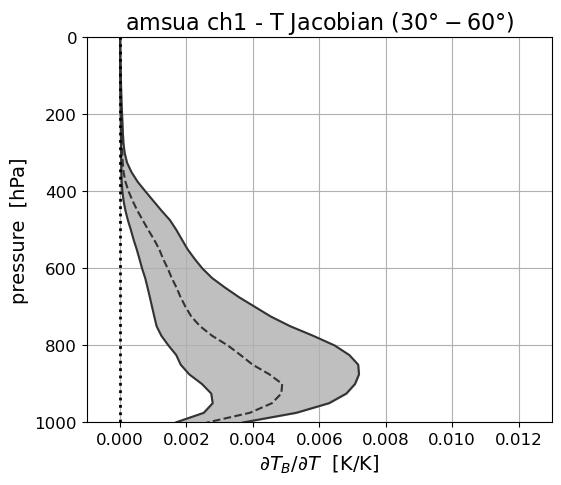

In [ ]:
# [30,60] degree T-jacobian

use = np.where( (np.abs(lat_use) >30) & (np.abs(lat_use) <=60) )

use_prof = t_interp[use[0],:]

prof_mean = np.mean(use_prof, axis=0)
prof_std  = np.std(use_prof, axis=0)
prof_q25  = np.quantile(use_prof, 0.25, axis=0)
prof_q50  = np.quantile(use_prof, 0.50, axis=0)
prof_q75  = np.quantile(use_prof, 0.75, axis=0)

use_jac = t_jac_interp[use[0],:]

jac_mean = np.mean(use_jac, axis=0)
jac_std  = np.std(use_jac, axis=0)
jac_q25  = np.quantile(use_jac, 0.25, axis=0)
jac_q50  = np.quantile(use_jac, 0.50, axis=0)
jac_q75  = np.quantile(use_jac, 0.75, axis=0)


# profile:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(prof_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(prof_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(prof_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, prof_q25, prof_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ T$ [K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(rf'{instr} ch{chn} - T profile ($30\degree-60\degree$)', fontsize=16)

if save_fig:
    plt.savefig(f'{instr}_ch{chn}_{ttt}_Tprof_30_60.png', dpi=200, bbox_inches='tight')

# jacobian
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, jac_q25, jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ \partial T_B / \partial T$  [K/K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(f'{instr} ch{chn} - T Jacobian ($30\degree-60\degree$)', fontsize=16)

if save_fig:
    plt.savefig(f'{instr}_ch{chn}_{ttt}_Tjac_30_60.png', dpi=200, bbox_inches='tight')


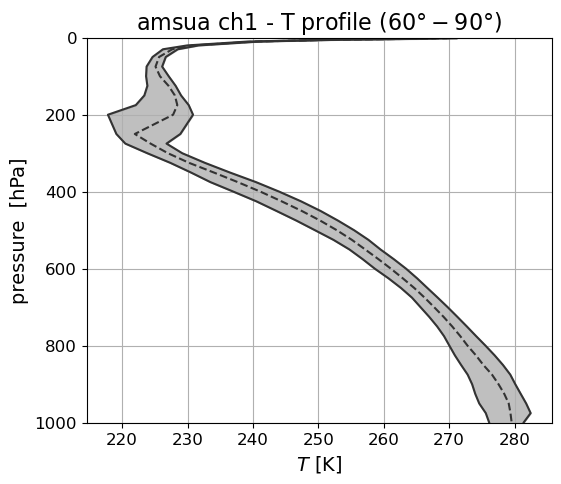

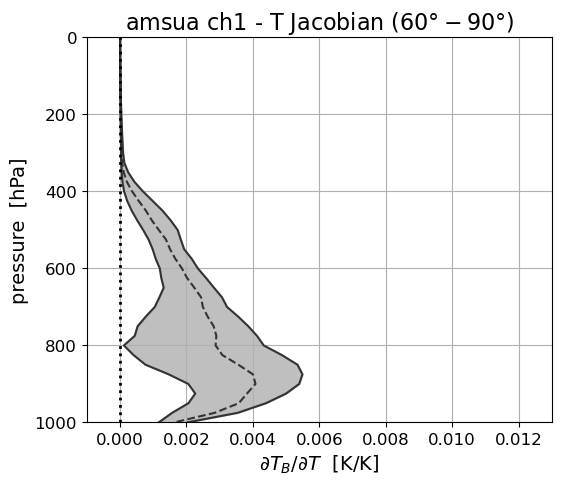

In [ ]:
# [60,90] degree T-jacobian

    
use = np.where( (np.abs(lat_use) >60) & (np.abs(lat_use) <=90) )

use_prof = t_interp[use[0],:]

prof_mean = np.mean(use_prof, axis=0)
prof_std  = np.std(use_prof, axis=0)
prof_q25  = np.quantile(use_prof, 0.25, axis=0)
prof_q50  = np.quantile(use_prof, 0.50, axis=0)
prof_q75  = np.quantile(use_prof, 0.75, axis=0)

use_jac = t_jac_interp[use[0],:]

jac_mean = np.mean(use_jac, axis=0)
jac_std  = np.std(use_jac, axis=0)
jac_q25  = np.quantile(use_jac, 0.25, axis=0)
jac_q50  = np.quantile(use_jac, 0.50, axis=0)
jac_q75  = np.quantile(use_jac, 0.75, axis=0)


# profile:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(prof_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(prof_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(prof_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, prof_q25, prof_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ T$ [K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(rf'{instr} ch{chn} - T profile ($60\degree-90\degree$)', fontsize=16)

if save_fig:
    plt.savefig(f'{instr}_ch{chn}_{ttt}_Tprof_60_90.png', dpi=200, bbox_inches='tight')

# jacobian
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, jac_q25, jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ \partial T_B / \partial T$  [K/K]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(f'{instr} ch{chn} - T Jacobian ($60\degree-90\degree$)', fontsize=16)

if save_fig:
    plt.savefig(f'{instr}_ch{chn}_{ttt}_Tjac_60_90.png', dpi=200, bbox_inches='tight')

Text(0.5, 1.0, 'amsua ch4 - $Q_L$ Jacobian (cloudy)')

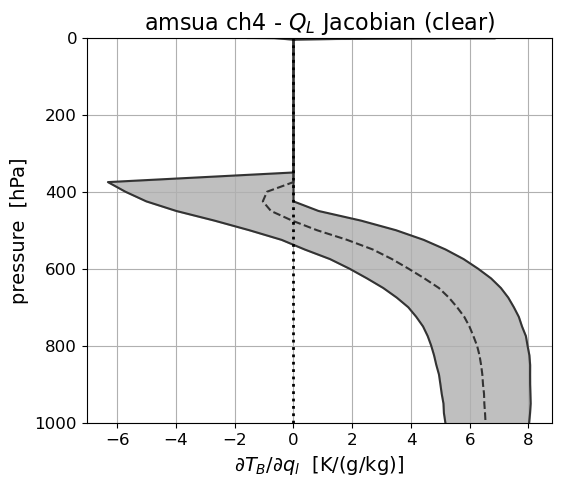

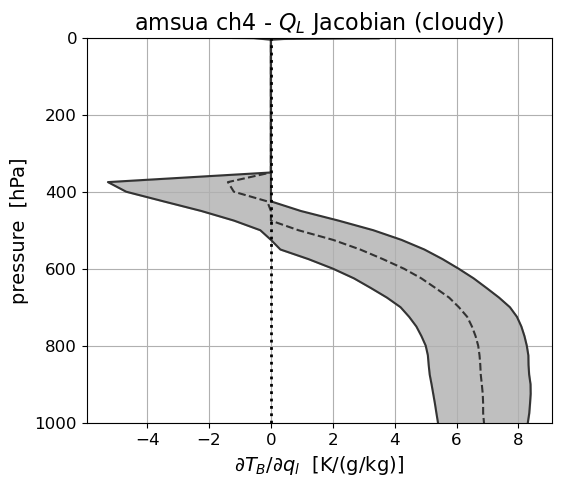

In [225]:
# clear/cloudy sky QL-profile and QL-jacobian:
#if chn == 4:
#    xlim_r = [-0.018, 0.018]

use_clr = np.where(clw_model_use <=0.03)
use_cld = np.where(clw_model_use  >0.03)

clr_prof = ql_interp[use_clr[0],:]
cld_prof = ql_interp[use_cld[0],:]

clr_prof_mean = np.mean(clr_prof, axis=0)
cld_prof_std  = np.std(clr_prof, axis=0)
clr_prof_q25  = np.quantile(clr_prof, 0.25, axis=0)
clr_prof_q50  = np.quantile(clr_prof, 0.50, axis=0)
clr_prof_q75  = np.quantile(clr_prof, 0.75, axis=0)
cld_prof_mean = np.mean(cld_prof, axis=0)
cld_prof_std  = np.std(cld_prof, axis=0)
cld_prof_q25  = np.quantile(cld_prof, 0.25, axis=0)
cld_prof_q50  = np.quantile(cld_prof, 0.50, axis=0)
cld_prof_q75  = np.quantile(cld_prof, 0.75, axis=0)


clr_jac  = ql_jac_interp[use_clr[0],:]
cld_jac  = ql_jac_interp[use_cld[0],:]

clr_jac_mean = np.mean(clr_jac, axis=0)
clr_jac_std  = np.std(clr_jac, axis=0)
clr_jac_q25  = np.quantile(clr_jac, 0.25, axis=0)
clr_jac_q50  = np.quantile(clr_jac, 0.50, axis=0)
clr_jac_q75  = np.quantile(clr_jac, 0.75, axis=0)
cld_jac_mean = np.mean(cld_jac, axis=0)
cld_jac_std  = np.std(cld_jac, axis=0)
cld_jac_q25  = np.quantile(cld_jac, 0.25, axis=0)
cld_jac_q50  = np.quantile(cld_jac, 0.50, axis=0)
cld_jac_q75  = np.quantile(cld_jac, 0.75, axis=0)


fig, ax = plt.subplots(figsize=(6,5))
#ax.plot(t_jac_interp[use_clr[0],:].T, pres_interp, color='gray')
ax.plot(clr_jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(clr_jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(clr_jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, clr_jac_q25, clr_jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ \partial T_B / \partial q_l$  [K/(g/kg)]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(rf'{instr} ch{chn} - $Q_L$ Jacobian (clear)', fontsize=16)

fig, ax = plt.subplots(figsize=(6,5))
#ax.plot(t_jac_interp[use_cld[0],:].T, pres_interp, color='gray')
ax.plot(cld_jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(cld_jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(cld_jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, cld_jac_q25, cld_jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ \partial T_B / \partial q_l$  [K/(g/kg)]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(rf'{instr} ch{chn} - $Q_L$ Jacobian (cloudy)', fontsize=16)



Text(0.5, 1.0, 'amsua ch4 - $Q_I$ Jacobian (cloudy)')

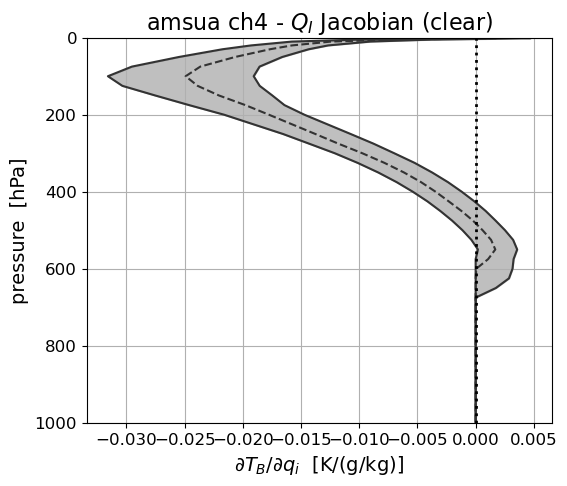

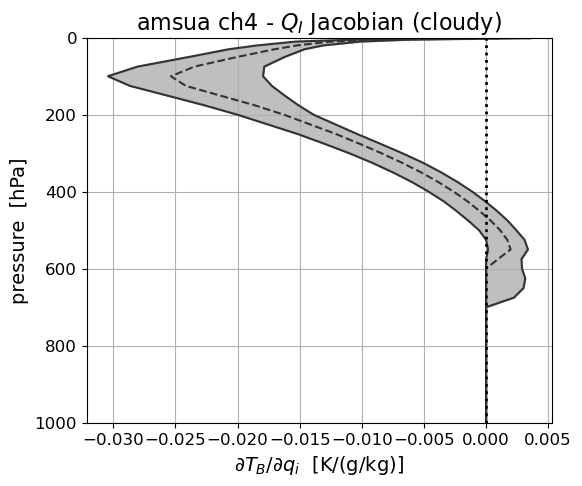

In [231]:
# clear/cloudy sky Qi-profile and Qi-jacobian:
if chn == 4:
    xlim_r = [-0.018, 0.018]

use_clr = np.where(clw_model_use <=0.03)
use_cld = np.where(clw_model_use  >0.03)

clr_prof = qi_interp[use_clr[0],:]
cld_prof = qi_interp[use_cld[0],:]

clr_prof_mean = np.mean(clr_prof, axis=0)
cld_prof_std  = np.std(clr_prof, axis=0)
clr_prof_q25  = np.quantile(clr_prof, 0.25, axis=0)
clr_prof_q50  = np.quantile(clr_prof, 0.50, axis=0)
clr_prof_q75  = np.quantile(clr_prof, 0.75, axis=0)
cld_prof_mean = np.mean(cld_prof, axis=0)
cld_prof_std  = np.std(cld_prof, axis=0)
cld_prof_q25  = np.quantile(cld_prof, 0.25, axis=0)
cld_prof_q50  = np.quantile(cld_prof, 0.50, axis=0)
cld_prof_q75  = np.quantile(cld_prof, 0.75, axis=0)


clr_jac  = qi_jac_interp[use_clr[0],:]
cld_jac  = qi_jac_interp[use_cld[0],:]

clr_jac_mean = np.mean(clr_jac, axis=0)
clr_jac_std  = np.std(clr_jac, axis=0)
clr_jac_q25  = np.quantile(clr_jac, 0.25, axis=0)
clr_jac_q50  = np.quantile(clr_jac, 0.50, axis=0)
clr_jac_q75  = np.quantile(clr_jac, 0.75, axis=0)
cld_jac_mean = np.mean(cld_jac, axis=0)
cld_jac_std  = np.std(cld_jac, axis=0)
cld_jac_q25  = np.quantile(cld_jac, 0.25, axis=0)
cld_jac_q50  = np.quantile(cld_jac, 0.50, axis=0)
cld_jac_q75  = np.quantile(cld_jac, 0.75, axis=0)


fig, ax = plt.subplots(figsize=(6,5))
#ax.plot(t_jac_interp[use_clr[0],:].T, pres_interp, color='gray')
ax.plot(clr_jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(clr_jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(clr_jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, clr_jac_q25, clr_jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ \partial T_B / \partial q_i$  [K/(g/kg)]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(rf'{instr} ch{chn} - $Q_I$ Jacobian (clear)', fontsize=16)

fig, ax = plt.subplots(figsize=(6,5))
#ax.plot(t_jac_interp[use_cld[0],:].T, pres_interp, color='gray')
ax.plot(cld_jac_q50, pres_interp, color=(0.2,0.2,0.2), linestyle='--')
ax.plot(cld_jac_q25, pres_interp, color=(0.2,0.2,0.2))
ax.plot(cld_jac_q75, pres_interp, color=(0.2,0.2,0.2))
ax.fill_betweenx(pres_interp, cld_jac_q25, cld_jac_q75, color='gray', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(x=0, color='black', linestyle=':', linewidth=2)
#ax.set_xlim(xlim_r[0], xlim_r[1])
ax.set_ylim(1000,0)
ax.set_xlabel(r'$ \partial T_B / \partial q_i$  [K/(g/kg)]', fontsize=14)
ax.set_ylabel('pressure  [hPa]', fontsize=14)
ax.grid(True)
ax.set_title(rf'{instr} ch{chn} - $Q_I$ Jacobian (cloudy)', fontsize=16)

In [230]:
len(use_cld[0])

625

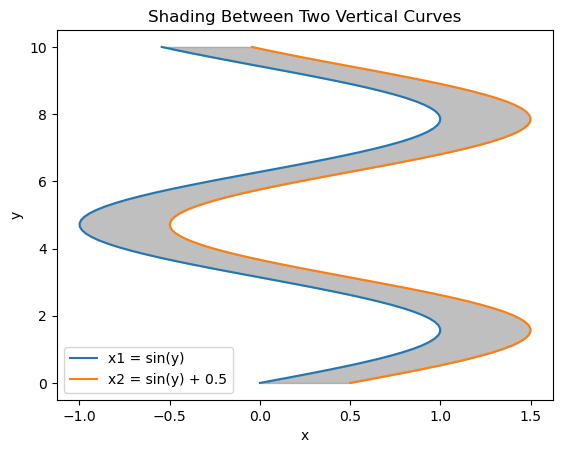

In [166]:
# Create y values (shared for both curves)
y = np.linspace(0, 10, 100)

# Define two vertical curves (x1 and x2 as functions of y)
x1 = np.sin(y)  # First vertical curve
x2 = np.sin(y) + 0.5  # Second vertical curve

# Plot the two vertical curves
plt.plot(x1, y, label='x1 = sin(y)')
plt.plot(x2, y, label='x2 = sin(y) + 0.5')

# Fill the area between x1 and x2 (for all y)
plt.fill_betweenx(y, x1, x2, where=(x2 > x1), color='gray', alpha=0.5)

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Shading Between Two Vertical Curves')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [158]:
clr_prof.shape

(1129, 46)